In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [73]:
df = pd.read_csv("measurements.csv", index_col=0)
df

,sample,batch_size,max_length,model_delta_memory,model_delta_time,inference_delta_memory,inference_delta_time,total_delta_memory,total_delta_time
0,0,1,50,2302287872,4.341798,41943040,0.157616,2344230912,4.499416
1,0,1,100,2338398208,4.027383,43941888,0.177645,2382340096,4.205030
2,0,1,250,2323193856,3.753077,42795008,0.186528,2365988864,3.939607
3,0,1,500,2315386880,4.347047,45875200,0.218441,2361262080,4.565490
4,0,2,50,2304385024,4.306310,44040192,0.162229,2348425216,4.468559
5,0,2,100,2320637952,3.466892,43778048,0.165192,2364416000,3.632087
6,0,2,250,2310414336,3.635084,46137344,0.198982,2356551680,3.834068
7,0,2,500,2336112640,3.952491,46268416,0.220079,2382381056,4.172572
8,0,4,50,2320637952,3.563506,46137344,0.195301,2366775296,3.758809
9,0,4,100,2315526144,3.447595,41680896,0.252871,2357207040,3.700467


In [ ]:
X = df[["batch_size", "max_length"]].to_numpy()
y = df["total_delta_memory"].to_numpy()

array([[  1,  50],
       [  1, 100],
       [  1, 250],
       [  1, 500],
       [  2,  50],
       [  2, 100],
       [  2, 250],
       [  2, 500],
       [  4,  50],
       [  4, 100],
       [  4, 250],
       [  4, 500],
       [  8,  50],
       [  8, 100],
       [  8, 250],
       [  8, 500],
       [ 16,  50],
       [ 16, 100],
       [ 16, 250],
       [ 16, 500],
       [ 24,  50],
       [ 24, 100],
       [ 24, 250],
       [ 24, 500],
       [ 32,  50],
       [ 32, 100],
       [ 32, 250],
       [ 32, 500],
       [ 48,  50],
       [ 48, 100],
       [ 48, 250],
       [ 48, 500],
       [ 64,  50],
       [ 64, 100],
       [ 64, 250],
       [ 64, 500]])

In [75]:
# Linear regression
linear_model = LinearRegression()
linear_model.fit(X, y)

LinearRegression()

In [76]:
# Polynomial regression
polynomial_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

polynomial_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('linear', LinearRegression())])

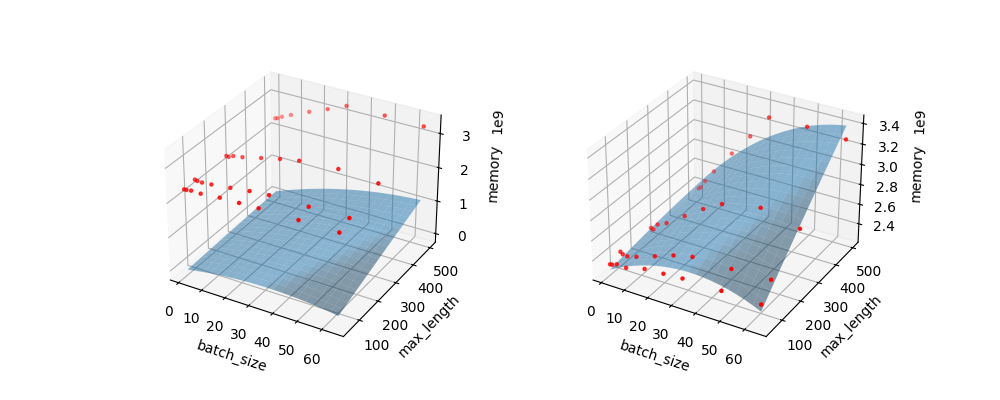

In [77]:
fig = plt.figure(figsize=(10,4))

def add_plot(subplot, model, samples=20):
    xx, yy = np.meshgrid(np.linspace(min(X[:,0]), max(X[:,0]), samples), np.linspace(min(X[:,1]), max(X[:,1]), samples))

    ax = fig.add_subplot(subplot, projection='3d')
    ax.scatter(X[:,0], X[:,1], y, marker='.', color='red')
    ax.set_xlabel("batch_size")
    ax.set_ylabel("max_length")
    ax.set_zlabel("memory")

    zz = model.predict(np.hstack((xx.reshape(-1,1), yy.reshape(-1,1)))).reshape(xx.shape)
    ax.plot_surface(xx,yy,zz, alpha=0.5)

add_plot(121, reconstructed_model)
add_plot(122, polynomial_model)

In [78]:
# Extracting components
import json
scaler_params = {
    'mean': polynomial_model.named_steps['scaler'].mean_.tolist(),
    'scale': polynomial_model.named_steps['scaler'].scale_.tolist()
}
poly_params = {
    'degree': polynomial_model.named_steps['poly'].degree,
    'n_input_features': polynomial_model.named_steps['poly'].n_features_in_
}
linear_params = {
    'coef': polynomial_model.named_steps['linear'].coef_.tolist(),
    'intercept': polynomial_model.named_steps['linear'].intercept_.tolist()
}

# Combine into one dictionary
model_data = {
    'scaler': scaler_params,
    'poly': poly_params,
    'linear': linear_params
}

# Save as JSON
with open('polynomial_model.json', 'w') as f:
    json.dump(model_data, f, indent=4)

In [79]:
# Load the JSON file
with open('polynomial_model.json', 'r') as f:
    model_data = json.load(f)

# Reconstruct the components
scaler = StandardScaler()
scaler.mean_ = np.array(model_data['scaler']['mean'])
scaler.scale_ = np.array(model_data['scaler']['scale'])

# PolynomialFeatures needs to be fitted
poly = PolynomialFeatures(degree=model_data['poly']['degree'])
n_input_features = model_data['poly']['n_input_features']
dummy_data = np.zeros((1, n_input_features))
poly.fit(dummy_data)  # Fit with dummy data

linear = LinearRegression()
linear.coef_ = np.array(model_data['linear']['coef'])
linear.intercept_ = np.array(model_data['linear']['intercept'])

# Rebuild the pipeline
reconstructed_model = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('linear', linear)
])